# TP2 - CV avec Keras

In [4]:
# Near Image detection

# Partie 1 - Manipulations de base avec Keras pour la classification d'image

## Test de Keras avec quelques images de référence

In [5]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np

model = VGG16(weights='imagenet', include_top=True)

for animal in ["elephant", "fish", "lion"]:
    img_path = f'image/{animal}.jpg'
    img = keras.utils.load_img(img_path, target_size=(224, 224))
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)

    predictedClasses = decode_predictions(features, top=5)[0]

    for predictedClass, desc, prob in predictedClasses:
        print(desc, prob)
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
African_elephant 0.7879816
tusker 0.16350208
Indian_elephant 0.048055366
Arabian_camel 0.0004574472
lion 8.2484115e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
anemone_fish 0.9976418
sea_anemone 0.00068965077
rock_beauty 0.00050836825
sea_slug 0.00035001806
coral_reef 0.0003233605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
lion 0.95971394
marmot 0.020596137
brown_bear 0.00417717
dhole 0.0040889136
Arabian_camel 0.00312778


## Définition et application d'un domaine d'adaptation: finetuning sur les chats et chiens

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras import layers

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import keras

In [ ]:
imageSize = 224
batchSize = 64

# load dataset
dataset_name = "cats_vs_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train[:75%]", "train[75%:]"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [13]:
# resize the datasets to the desired size
size = (imageSize, imageSize)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

2025-01-08 02:33:52.265924: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


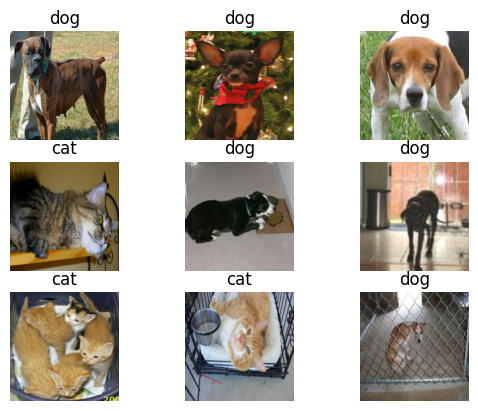

In [17]:
# visualize the first 9 images of the training dataset
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label

label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

2025-01-08 02:34:20.538174: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


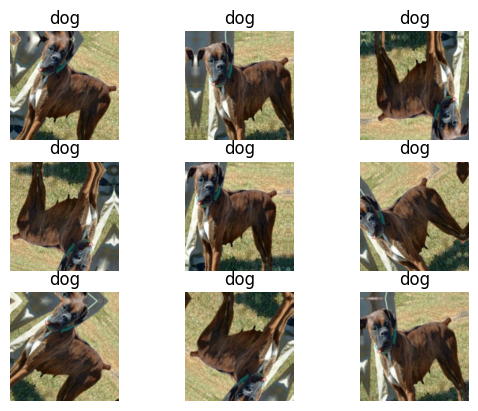

In [19]:
# data augmentation by randomly rotating, translating, flippign and changing the contrast of the images
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")



In [20]:
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=batchSize, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=batchSize, drop_remainder=True)

In [24]:
def buildModel(nbClasses):
    inputs = layers.Input(shape=(imageSize, imageSize, 3))

    model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(nbClasses, activation="softmax", name="pred")(x)
    
    model = keras.Model(inputs, outputs, name="VGG16")
    optimizer = keras.optimizers.Adam(learning_rate=0.005)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy()]
    )
    
    return model

In [ ]:
# train the first layer 
model = buildModel(nbClasses=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

print(hist)
# plt.title("Training and validation accurary")
# plt.plot(, label="")
# plt.plot(, label="")

# plot_hist(hist)


Epoch 1/25
  2/272 ━━━━━━━━━━━━━━━━━━━━ 32:37 7s/step - binary_accuracy: 0.5781 - loss: 0.7900